In [1]:
import numpy as np
from matplotlib import pyplot as plt
import cv2
import torch

In [2]:
#!pip install torch

In [3]:
#!pip install torchvision

In [4]:
#!pip install opencv-contrib-python

In [5]:
from torch import nn, optim
from torchvision import datasets, transforms
import zipfile
import tensorflow as tf
#from tensorflow import keras
import keras
#from tensorflow.keras import layers
from keras import layers
#from tensorflow.keras.datasets import cifar10
from keras.datasets import cifar10
import datetime
from IPython.display import display, Javascript
from base64 import b64decode

In [6]:
def take_photo(filename='photo.jpg', quality=0.8):
    js = Javascript('''
        async function takePhoto(quality) {
            const div = document.createElement('div');
            const capture = document.createElement('button');
            capture.textContent = 'Capture';
            div.appendChild(capture);

            const video = document.createElement('video');
            video.style.display = 'block';
            const stream = await navigator.mediaDevices.getUserMedia({video: true});

            document.body.appendChild(div);
            div.appendChild(video);
            video.srcObject = stream;
            await video.play();

            // Resize the output to fit the video element.
            google.colab.output.setIframeHeight(document.documentElement.scrollHeight, true);

            // Wait for Capture to be clicked.
            await new Promise((resolve) => capture.onclick = resolve);

            const canvas = document.createElement('canvas');
            canvas.width = video.videoWidth;
            canvas.height = video.videoHeight;
            canvas.getContext('2d').drawImage(video, 0, 0);
            stream.getVideoTracks()[0].stop();
            div.remove();
            return canvas.toDataURL('image/jpeg', quality);
        }
        ''')
    display(js)
    data = eval_js('takePhoto({})'.format(quality))
    binary = b64decode(data.split(',')[1])
    with open(filename, 'wb') as f:
        f.write(binary)
    return filename

In [40]:
from IPython.display import Image
image = Image('eu.jpeg')

In [41]:
image = cv2.imread('eu.jpeg')

In [42]:
#!pip install opencv-contrib-python

In [43]:
ss = cv2.ximgproc.segmentation.createSelectiveSearchSegmentation()
ss.setBaseImage(image)

In [44]:
ss.switchToSelectiveSearchQuality()

In [45]:
retangulos = ss.process()

In [46]:
retangulos.shape

(9112, 4)

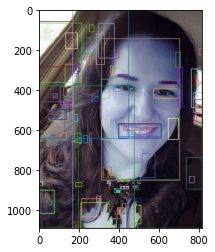

In [47]:
k = 30
retangulos_aleatorios = retangulos[np.random.randint(low = 0, high = retangulos.shape[0], size = k),]
output = image.copy()
for (a, b, w, h) in retangulos[0:100,]:
		color = [np.random.randint(0, 255) for j in range(0, 3)]
		cv2.rectangle(output, (a, b), (a + w, b + h), color, 2)

plt.imshow(output)

In [16]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.cifar10.load_data()

170498071/170498071 [==============================] - 12s 0us/step


In [17]:
classificador = nn.Sequential(nn.Conv2d(in_channels=3, out_channels=32, kernel_size = 3),
                              nn.ReLU(),
                              nn.BatchNorm2d(num_features=32),
                              nn.MaxPool2d(kernel_size = 2),
                              nn.Conv2d(32, 32, 3),
                              nn.ReLU(),
                              nn.BatchNorm2d(32),
                              nn.MaxPool2d(2),
                              nn.Flatten(),
                              nn.Linear(in_features=14*14*32, out_features=128),
                              nn.ReLU(),
                              nn.Dropout(0.2),
                              nn.Linear(128, 128),
                              nn.ReLU(),
                              nn.Dropout(0.2),
                              nn.Linear(128, 1),
                              nn.Sigmoid())

In [18]:
criterion = nn.BCELoss()
optimizer = optim.Adam(classificador.parameters())

In [21]:
path = './dataset.zip'
zip_object = zipfile.ZipFile(path, 'r')
zip_object.extractall('./')
zip_object.close()

In [22]:
data_dir_train = 'dataset/training_set'
data_dir_test = 'dataset/test_set'

In [23]:
transform_train = transforms.Compose(
    [
     transforms.Resize([64, 64]),
     transforms.RandomHorizontalFlip(),
     transforms.RandomAffine(degrees=7, translate=(0, 0.07), shear=0.2, scale=(1, 1.2)),
     transforms.ToTensor()
    ]
)

In [24]:
transform_test = transforms.Compose(
    [
     transforms.Resize([64, 64]),
     transforms.ToTensor()
    ]
)

In [25]:
train_dataset = datasets.ImageFolder(data_dir_train, transform=transform_train)

In [26]:
train_dataset

Dataset ImageFolder
    Number of datapoints: 1176
    Root location: dataset/training_set
    StandardTransform
Transform: Compose(
               Resize(size=[64, 64], interpolation=bilinear, max_size=None, antialias=None)
               RandomHorizontalFlip(p=0.5)
               RandomAffine(degrees=[-7.0, 7.0], translate=(0, 0.07), scale=(1, 1.2), shear=[-0.2, 0.2])
               ToTensor()
           )

In [27]:
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size = 32, shuffle=True)

In [28]:
# test_dataset = datasets.ImageFolder(data_dir_test, transform=transform_test)

In [29]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
device

device(type='cpu')

In [30]:
classificador.to(device)

Sequential(
  (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1))
  (1): ReLU()
  (2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (4): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1))
  (5): ReLU()
  (6): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (8): Flatten(start_dim=1, end_dim=-1)
  (9): Linear(in_features=6272, out_features=128, bias=True)
  (10): ReLU()
  (11): Dropout(p=0.2, inplace=False)
  (12): Linear(in_features=128, out_features=128, bias=True)
  (13): ReLU()
  (14): Dropout(p=0.2, inplace=False)
  (15): Linear(in_features=128, out_features=1, bias=True)
  (16): Sigmoid()
)

In [31]:
def training_loop(loader, epoch):
    running_loss = 0.
    running_accuracy = 0.
    
    for i, data in enumerate(loader):
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()        
        outputs = classificador(inputs)
        
        loss = criterion(outputs, labels.float().view(*outputs.shape))
        loss.backward()
        
        optimizer.step()

        running_loss += loss.item()

        predicted = torch.tensor([1 if output > 0.5 else 0 for output in outputs]).to(device)
        
        equals = predicted == labels.view(*predicted.shape)
        
        accuracy = torch.mean(equals.float())
        running_accuracy += accuracy
                   
        # Imprimindo os dados referentes a esse loop
        print('\rÉPOCA {:3d} - Loop {:3d} de {:3d}: perda {:03.2f} - precisão {:03.2f}'.format(epoch + 1, i + 1, len(loader), loss, accuracy), end = '\r')
        
    # Imprimindo os dados referentes a essa época
    print('\rÉPOCA {:3d} FINALIZADA: perda {:.5f} - precisão {:.5f}'.format(epoch + 1, running_loss/len(loader), 
                    running_accuracy/len(loader)))


In [32]:
for epoch in range(10):
    print('Treinando...')
    training_loop(train_loader, epoch)
    classificador.eval()
    print('Validando...')
    training_loop(train_loader, epoch)
    classificador.train()

Treinando...
ÉPOCA   1 FINALIZADA: perda 0.72639 - precisão 0.49296
Validando...
ÉPOCA   1 FINALIZADA: perda 0.72231 - precisão 0.46959
Treinando...
ÉPOCA   2 FINALIZADA: perda 0.71811 - precisão 0.46453
Validando...
ÉPOCA   2 FINALIZADA: perda 0.70890 - precisão 0.48423
Treinando...
ÉPOCA   3 FINALIZADA: perda 0.70816 - precisão 0.49099
Validando...
ÉPOCA   3 FINALIZADA: perda 0.70968 - precisão 0.50310
Treinando...
ÉPOCA   4 FINALIZADA: perda 0.70229 - precisão 0.48874
Validando...
ÉPOCA   4 FINALIZADA: perda 0.70459 - precisão 0.50873
Treinando...
ÉPOCA   5 FINALIZADA: perda 0.70434 - precisão 0.50676
Validando...
ÉPOCA   5 FINALIZADA: perda 0.70180 - precisão 0.49268
Treinando...
ÉPOCA   6 FINALIZADA: perda 0.69819 - precisão 0.48423
Validando...
ÉPOCA   6 FINALIZADA: perda 0.69919 - precisão 0.45805
Treinando...
ÉPOCA   7 FINALIZADA: perda 0.69885 - precisão 0.48733
Validando...
ÉPOCA   7 FINALIZADA: perda 0.69726 - precisão 0.46030
Treinando...
ÉPOCA   8 FINALIZADA: perda 0.69777

In [33]:
def classificar_imagem(fname):
    from PIL import Image
    import matplotlib.pyplot as plt
    imagem_teste = Image.open(data_dir_test + '/' + fname)
    plt.imshow(imagem_teste)

    import numpy as np
    imagem_teste = imagem_teste.resize((64, 64))
    imagem_teste = np.array(imagem_teste.getdata()).reshape(*imagem_teste.size, 3)
    imagem_teste = imagem_teste / 255
    imagem_teste = imagem_teste.transpose(2, 0, 1)
    imagem_teste = torch.tensor(imagem_teste, dtype=torch.float).view(-1, *imagem_teste.shape)

    classificador.eval()
    imagem_teste = imagem_teste.to(device)
    output = classificador.forward(imagem_teste)
    if output > 0.5:
        output = 1
    else:
        output = 0
    print('Previsão: ', output)

    idx_to_class = {value: key for key, value in train_dataset.class_to_idx.items()}

    return idx_to_class[output]

Previsão:  0


'cachorro'

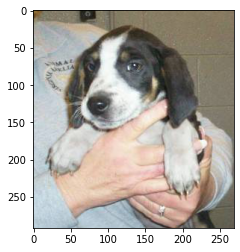

In [39]:
imagem = 'cachorro/dog.10.jpg'
classificar_imagem(imagem)